In [1]:
import tensorflow as tf
# if the import fails, try to install tf : pip install --upgrade tensorflow
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
n = x_train.shape[0]
d_inputs = 28 * 28
d_hidden1 = 100
d_hidden2 = 10  # codings
d_hidden3 = d_hidden1
d_outputs = d_inputs
n_class = 10

learning_rate = 1e-1
l2_reg = 0.0005
batch_size = 10
steps = n//batch_size
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=500,
    decay_rate=0.96)

activation = tf.nn.elu

In [4]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))/255 - 0.5
x_train = x_train.astype('float32')
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))/255 - 0.5
x_test = x_test.astype('float32')

In [5]:
class AE(tf.Module):
    def __init__(self, unit_nbrs, name=None):
        super().__init__(name=name)
        self.w = []
        self.b = []
        self.K = len(unit_nbrs)-1
        for i in range(self.K):            
            self.w.append(tf.Variable(tf.random.normal([unit_nbrs[i],unit_nbrs[i+1]],seed = 150), name='w'+str(i+1)))
            self.b.append(tf.Variable(tf.zeros([unit_nbrs[i+1]]), name='b'+str(i+1)))
        for i in range(self.K):
            self.w.append(tf.Variable(tf.transpose(self.w[self.K-i-1]), name='w'+str(self.K+i+1)))            
            self.b.append(tf.Variable(tf.zeros([unit_nbrs[self.K-i-1]]), name='b'+str(self.K+i+1)))  
        
    @tf.function
    def __call__(self, x):
        z = [x]
        for i in range(self.K): 
            z.append(activation(tf.matmul(z[-1],self.w[i]) + self.b[i]))
        for i in range(self.K): 
            z.append(activation(tf.matmul(z[-1],self.w[i+self.K]) + self.b[i+self.K]))
        return z[-1]
    
def loss(target,pred):
    return tf.math.reduce_mean(tf.math.squared_difference(target, pred))  

def reg(model,l2_reg):
    term = 0
    for coef in model.trainable_variables:
        if (coef.name[0]=='w'):
            term += tf.norm(coef, ord=2)
    return l2_reg*term

In [6]:
if __name__ == '__main__':
    my_AE = AE([d_inputs,d_hidden1,d_hidden2], name="the_model")
    print("Model results:", my_AE(x_train[0:2]))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Model results: tf.Tensor(
[[1362.2296   155.9292  2731.1245  ...  928.57916 3555.1846  2382.332  ]
 [2347.128   1063.4158  1828.5098  ... 1077.9344  1432.637   1139.9896 ]], shape=(2, 784), dtype=float32)


In [7]:

    n_epochs = 6
    
    for epoch in range(n_epochs):
        for step in range(steps):
            # Computing the function meanwhile recording a gradient tape
            with tf.GradientTape() as tape:
                x=x_train[batch_size * step : batch_size*(step+1)]
                train_loss = loss(x,my_AE(x)) + reg(my_AE,l2_reg)

            grads = tape.gradient(train_loss,my_AE.trainable_variables)
            optimizer.apply_gradients(zip(grads, my_AE.trainable_variables))
            print("\rEpoch %d - %d%% - \tf=%s" % (epoch, int(step/steps*100), train_loss.numpy()),end="")

Epoch 5 - 99% - 	f=0.042378496

Inputs: [-0.5 -0.5 -0.5 -0.5 -0.5]
Model results: tf.Tensor([-0.5 -0.5 -0.5 -0.5 -0.5], shape=(5,), dtype=float32)
Test MSE = tf.Tensor(0.042743925, shape=(), dtype=float32)


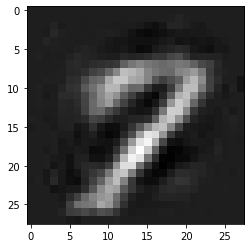

In [37]:
ind = 15
print("Inputs:", x_train[ind:ind+1][0,:5])
print("Model results:", my_AE(x_train[ind:ind+1])[0,:5])
x_tilde = x_train[ind:ind+1]
x_tilde = my_AE(x_train[ind:ind+1]).numpy()
#print('x_tilde = ',x_tilde)

plt.imshow(np.reshape(x_tilde,(28,28)), cmap='gray', interpolation="nearest")

x_tilde_test = my_AE(x_test)
test_loss = loss(x_test,x_tilde_test)
print("Test MSE =",test_loss)

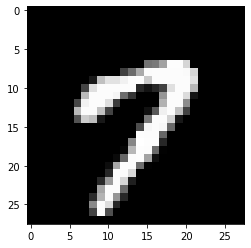

In [38]:
plt.imshow(x_train[ind].reshape((28,28)), cmap='gray', interpolation="nearest")
plt.show()

Ici, pour obtenir de bons résultats, nous avons dû abandonner l'hypothèse de W3 = W2.T et W4 = W1.T. Nous initialisons ici les valeurs de W3 et W4 comme les transposée de W1 et W2 mais l'évolution de ces matrices s'éloignent ensuite des transposés de W1 et W2.

Ainsi, l'algorithme apprend 4 matrices de poids différentes au lieu de 2.

De même nous n'obtenons de bons résultats qu'après 6 époques d'entraînement.

Même après tous ces changements, cela ne fonctionne que partiellement pour certains chiffres comme le 5 par exemple.